<a href="https://colab.research.google.com/github/BastionJader/SDI-IBM-Capstone-Project/blob/main/capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.9/438.9 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.65
    Uninstalling langchain-core-0.3.65:
      Successfully uninstalled langchain-core-0.3.65
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.25
    Uninstalling langchain-0.3.25:
      Successfully uninstalled langchain-0.3.25
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
# Set the API token
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
)

In [3]:
from datasets import load_dataset
import pandas as pd

splits = {'train': 'train_all.csv', 'validation': 'val_all.csv', 'test': 'test_all.csv'}
df = pd.read_csv("hf://datasets/jbeno/sentiment_merged/" + splits["train"])


# Lihat 5 data pertama
df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,sentence,label,source,split
0,Those 2 drinks are part of the HK culture and ...,negative,dynasent_r2,train
1,I was told by the repair company that was doin...,negative,dynasent_r1,train
2,It is there to give them a good time .,neutral,sst_local,train
3,Like leafing through an album of photos accomp...,negative,sst_local,train
4,Johnny was a talker and liked to have fun.,positive,dynasent_r1,train


In [4]:
df = df.drop(columns=['source', 'split'])
df.columns

Index(['sentence', 'label'], dtype='object')

In [5]:
sample_review = df['sentence'][0]
print(sample_review)

Those 2 drinks are part of the HK culture and has years of history. It is so bad.


In [6]:
prompt = f"""Classify the sentiment of the following sentence as Positive, Negative or Neutral:

Review: "{sample_review}"

Sentiment:"""

response = output.invoke(prompt)

print("Review:", sample_review)
print("Predicted Sentiment:", response)

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.
Predicted Sentiment: Negative

Explanation:
The sentence expresses a negative opinion about the drinks despite acknowledging their cultural significance. The phrase "It is so bad" indicates a negative sentiment. The initial part of the sentence provides context, but the final statement clearly conveys dissatisfaction.


In [7]:
df['label'].value_counts()

,count
label,
neutral,49148
positive,31039
negative,21910


In [13]:
import re

review_batch = df['sentence'][:50].tolist()
actual_labels = df['label'][:50].tolist()

def clean_sentiment(text):
    """Ekstrak label Positive, Negative, atau Neutral dari output model."""
    match = re.search(r"\b(positive|negative|neutral)\b", text.lower())
    return match.group(1).capitalize() if match else "Unknown"
predictions = []
# Loop prediksi
for i, (review, actual) in enumerate(zip(review_batch, actual_labels)):
    prompt = f"""Classify the sentiment of the following sentence as Positive, Negative, or Neutral.
Also explain your reasoning.

Review: "{review}"

Sentiment:"""

    response = output.invoke(prompt)

    # Ekstrak label saja
    predicted = clean_sentiment(response)

    # Simpan label + seluruh penjelasan
    predictions.append({
        'review': review,
        'actual_sentiment': actual.capitalize(),
        'predicted_sentiment': predicted,
        'model_output': response.strip()  # simpan seluruh output model
    })

    # Tampilkan ringkasan
    print(f"{i+1}. Actual: {actual.capitalize()} | Predicted: {predicted}")
    print("Explanation:", response.strip())
    print("-" * 50)


1. Actual: Negative | Predicted: Negative
Explanation: The sentiment of the given review is Negative. 

Reasoning: The review starts by acknowledging the cultural significance and history of two drinks in Hong Kong ("Those 2 drinks are part of the HK culture and has years of history"), which implies a neutral or positive stance towards them. However, the concluding statement "It is so bad" clearly expresses a negative sentiment, indicating disapproval or dissatisfaction with these drinks. Therefore, despite the initial recognition of their cultural importance, the overall sentiment leans negative due to the explicit criticism in the final part of the review.
--------------------------------------------------
2. Actual: Negative | Predicted: Negative
Explanation: The sentiment of the review is Negative. The user expresses dissatisfaction with the repair company's assessment of their car's rim damage. The company's statement that fixing the rim was "impossible" and suggesting replacement

In [14]:
def clean_sentiment(text):
    """Ekstrak hanya 'Positive' atau 'Negative' atau 'Neutral' dari teks."""
    match = re.search(r"\b(positive|negative)\b", text.lower())
    return match.group(1).capitalize() if match else "Unknown"

# Hitung jumlah benar
correct = sum(
    1 for p in predictions
    if clean_sentiment(p['predicted_sentiment']) == clean_sentiment(p['actual_sentiment'])
)

total = len(predictions)
accuracy = correct / total * 100

# Tampilkan hasil
print(f"Total Prediksi: {total}")
print(f"Benar: {correct}")
print(f"Akurasi: {accuracy:.2f}%")

Total Prediksi: 50
Benar: 30
Akurasi: 60.00%


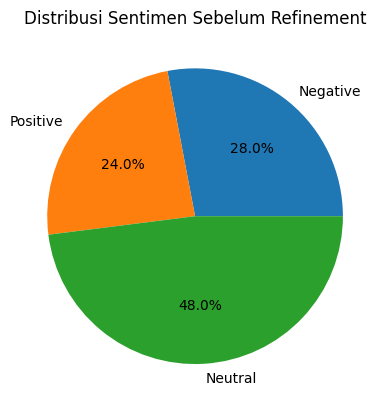

In [15]:
import matplotlib.pyplot as plt
from collections import Counter

counts = Counter([p['predicted_sentiment'] for p in predictions])
plt.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%')
plt.title("Distribusi Sentimen Sebelum Refinement")
plt.show()


In [16]:
refined_params = {
    "top_k": 5,
    "top_p": 0.9,
    "max_tokens": 128,
    "repetition_penalty": 1.5
}

In [17]:
import re

def extract_sentiment_and_focus(text):
    """Ekstrak Sentiment dan Focus Area dari output model"""
    sentiment = re.search(r"Sentiment:\s*(Positive|Negative|Neutral)", text, re.IGNORECASE)
    focus = re.search(r"Focus Area:\s*(.+)", text, re.IGNORECASE)
    return {
        "sentiment": sentiment.group(1).capitalize() if sentiment else "Unknown",
        "focus_area": focus.group(1).strip() if focus else "Unknown"
    }

# Reset prediksi
predictions_refined = []

# Refined loop
for i, (review, actual) in enumerate(zip(review_batch, actual_labels)):
    prompt = f"""Classify the sentiment of the following sentence into one of the following categories: Positive, Negative, or Neutral.

If relevant, also identify the main focus area (such as: product quality, utterance, service, price, delivery, daily life, or weather).

Consider explicit and implicit expressions of sentiment:
- Positive sentiment can include overt praise, satisfaction, or subtle appreciation.
example:"this time we skipped the combo and ordered individual meat dishes
the portions are similar but you might save a little money by doing the combo."
this is a positive sentence because the speaker is telling the other person that he saved money meaning the other person is making a profit
- Negative sentiment can include outright complaints or more subtle dissatisfaction, disappointment, or frustration. example "There are no small buildings for the dog to go through, it's basically just a grassy patch for the dog to run around in." meaning it's a sentence of disappointment because there are no buildings for the dog to go through because they're too small
- Neutral sentiment reflects the absence of overt emotional expression, or a factual statement without judgment.
example: "They called me during dinner."
It is a neutral explicit sentence because it does not show disappointment or pleasure like "unfortunately they called me during dinner" or "fortunately they called me during dinner"
Another example is "nothing frozen" is a neutral sentence because even though there is the word "nothing" it does not mean negative because in the sentence there is no feeling of sadness, disappointment, or anger, so it is a neutral sentence.

Respond in this format:
Sentiment: <Positive/Negative/Neutral>
Focus Area: <...>
Explanation: <...>

Sentence: "{review}"
"""

    # Panggil model dengan parameter refined
    response = output.invoke(prompt, parameters=refined_params)

    # Ekstrak hasil
    parsed = extract_sentiment_and_focus(response)

    # Simpan hasil
    predictions_refined.append({
        'review': review,
        'actual_sentiment': actual.capitalize(),
        'predicted_sentiment': parsed["sentiment"],
        'focus_area': parsed["focus_area"],
        'model_output': response.strip()
    })

    # Print
    print(f"{i+1}. Actual: {actual.capitalize()} | Predicted: {parsed['sentiment']} | Focus: {parsed['focus_area']}")
    print("Explanation:", response.strip())
    print("-" * 50)


1. Actual: Negative | Predicted: Negative | Focus: Product/Service (specifically, traditional drinks in Hong Kong culture)
Explanation: Sentiment: Negative
Focus Area: Product/Service (specifically, traditional drinks in Hong Kong culture)
Explanation: The sentence expresses a negative sentiment towards the traditional drinks of Hong Kong culture. Despite initially acknowledging their historical significance and cultural importance ("Those 2 drinks are part of the HK culture and has years of history."), the speaker then directly states "It is so bad," which indicates a clear negative evaluation of the drinks' quality or taste.
--------------------------------------------------
2. Actual: Negative | Predicted: Negative | Focus: Service
Explanation: Sentiment: Negative
Focus Area: Service
Explanation: The speaker expresses dissatisfaction with the car repair service, as the repair company declared fixing the rim "impossible" and instead suggested replacing it. This indicates a negative s

In [18]:
# Gunakan predictions_refined, bukan predictions
correct = sum(
    1 for p in predictions_refined
    if p['actual_sentiment'].lower() == p['predicted_sentiment'].lower()
)

total = len(predictions_refined)
accuracy = correct / total * 100

print(f"Total Prediksi: {total}")
print(f"Benar: {correct}")
print(f"Akurasi Refined: {accuracy:.2f}%")


Total Prediksi: 50
Benar: 42
Akurasi Refined: 84.00%


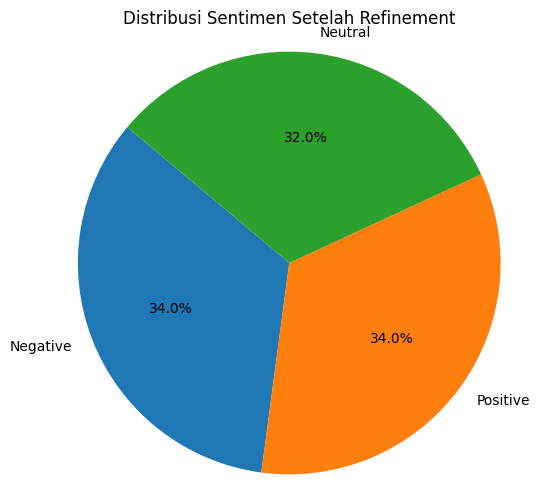

In [19]:
import matplotlib.pyplot as plt
from collections import Counter

# Ambil label hasil refined
labels_refined = [p['predicted_sentiment'] for p in predictions_refined]
counts = Counter(labels_refined)

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Distribusi Sentimen Setelah Refinement")
plt.axis('equal')
plt.show()


In [20]:
for i in range(len(predictions)):
    default_pred = predictions[i]['predicted_sentiment']
    refined_pred = predictions_refined[i]['predicted_sentiment']
    actual = predictions[i]['actual_sentiment']

    if default_pred != refined_pred:
        print(f"#{i+1}")
        print(f"Actual:   {actual}")
        print(f"Default:  {default_pred}")
        print(f"Refined:  {refined_pred}")
        print("-" * 30)


#4
Actual:   Negative
Default:  Neutral
Refined:  Negative
------------------------------
#5
Actual:   Positive
Default:  Neutral
Refined:  Positive
------------------------------
#18
Actual:   Negative
Default:  Neutral
Refined:  Negative
------------------------------
#19
Actual:   Negative
Default:  Neutral
Refined:  Negative
------------------------------
#21
Actual:   Positive
Default:  Neutral
Refined:  Positive
------------------------------
#25
Actual:   Neutral
Default:  Negative
Refined:  Neutral
------------------------------
#27
Actual:   Positive
Default:  Neutral
Refined:  Positive
------------------------------
#28
Actual:   Neutral
Default:  Negative
Refined:  Neutral
------------------------------
#34
Actual:   Positive
Default:  Neutral
Refined:  Positive
------------------------------
#36
Actual:   Neutral
Default:  Negative
Refined:  Neutral
------------------------------
#41
Actual:   Negative
Default:  Neutral
Refined:  Negative
------------------------------
#42
